In [ ]:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("tidyr")
install.packages("reticulate")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
if (!require("utils")) {
    install.packages("utils")
    library(utils)
}


In [ ]:
unzip("/demo-out-20240428T164842Z-001.zip", exdir = "/content")

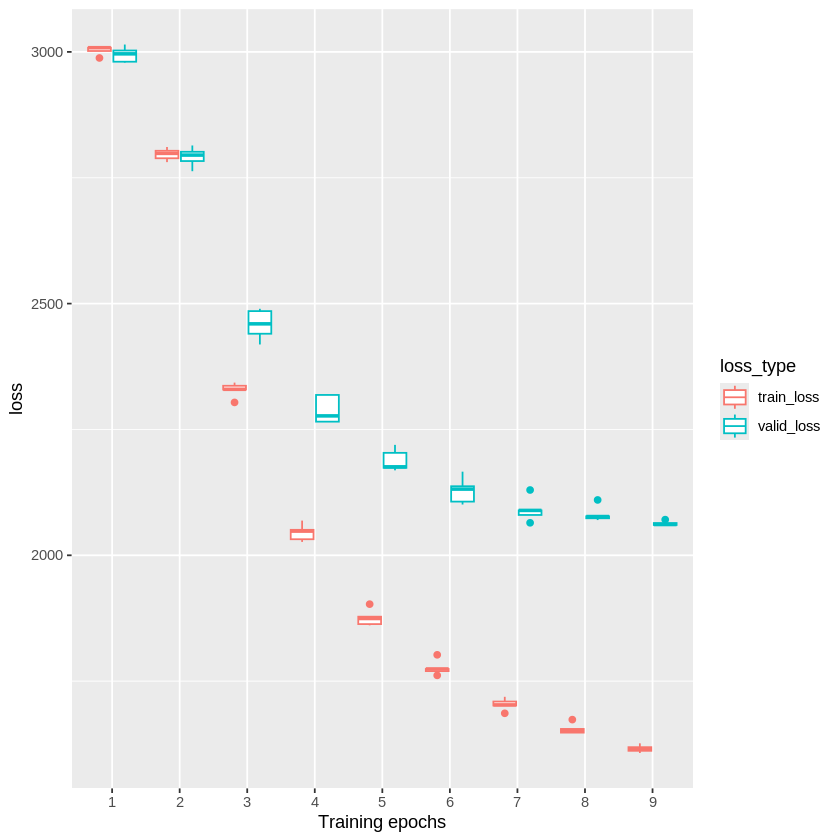

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)

# collect training loss
list.files("/content/demo-out",pattern = "train_loss.txt",full.names = TRUE,recursive = TRUE)%>%
  lapply(., function(x){
    read.delim(x,sep = ",",header = F)%>%
      mutate(trial=dirname(x)%>%basename(),
             step=1:n())%>%
      dplyr::select(trial,step,train_loss = V1)%>%
      return()
  })%>%
  bind_rows() -> loss_ds

# collect validation loss
list.files("/content/demo-out",pattern = "valid_loss.txt",full.names = TRUE,recursive = TRUE)%>%
  lapply(., function(x){
    read.delim(x,sep = ",",header = F)%>%
      mutate(trial=dirname(x)%>%basename(),
             step=1:n())%>%
      dplyr::select(trial,step,valid_loss = V1)%>%
      return()
  })%>%
  bind_rows()%>%
  inner_join(loss_ds,.,by=c("trial","step"))%>%
  group_by(trial)%>%
  filter(1:n() <= which(valid_loss==min(valid_loss)))-> loss_ds

loss_ds%>%gather(loss_type,loss,-trial,-step)%>%
    ggplot(.,aes(as.factor(step),loss,color=loss_type))+
  geom_boxplot()+
  xlab("Training epochs")

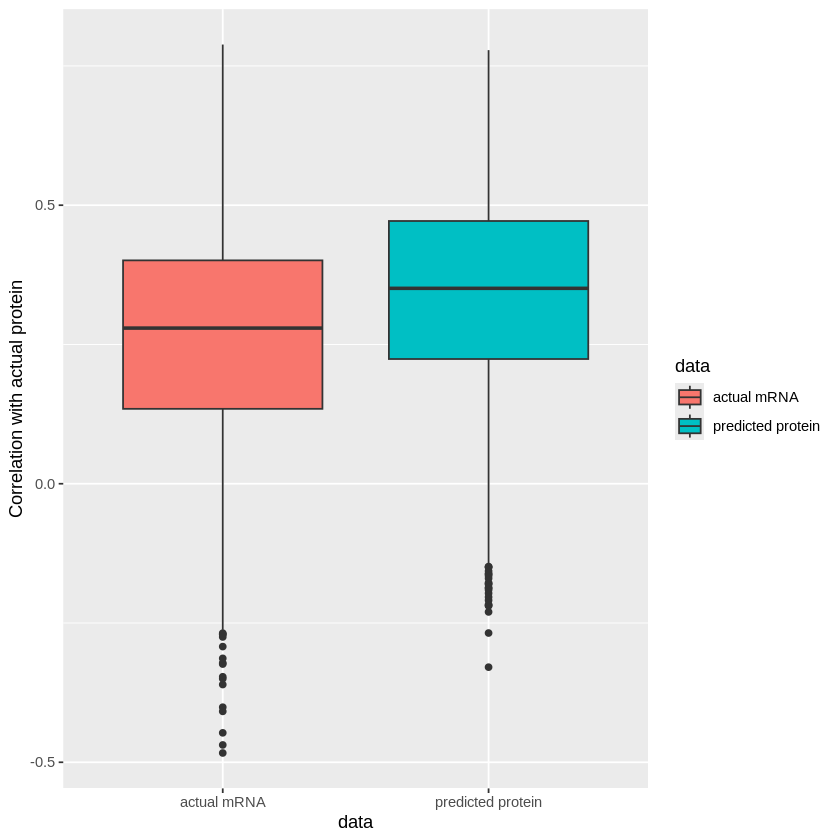

In [ ]:
library(reticulate)
np=import("numpy")

# collect test prediction
list.files("/content/demo-out",pattern = "test_prediction.npy",full.names = TRUE,recursive = TRUE)%>%
  lapply(., function(x){
    np$load(x)%>%
      as.matrix()%>%
      t()%>%
      return()
  }) -> pred_protein

# consensus prediction
for(i in 2:length(pred_protein)){
  pred_protein[1][[1]]=pred_protein[1][[1]]+pred_protein[i][[1]]
}
pred_protein = pred_protein[1][[1]] # this is a protein by sample matrix predicted by the clei2block model


# read actual measurements
acutal_protein = read.delim("/content/test_y.txt",header = F)%>%as.matrix()
acutal_mRNA = read.delim("/content/test_lr_x_mRNA.txt",header = F)%>%as.matrix()

# calculate correlation between predicted protein and acutal protein measurement for each gene across samples
lapply(1:nrow(acutal_protein), function(i){
  cor(pred_protein[i,],acutal_protein[i,])
})%>%unlist() -> pre_cor

# calculate correlation between acutal protein measurement and thier corresponding mRNA for each gene across samples
lapply(1:nrow(acutal_protein), function(i){
  cor(acutal_mRNA[i,],acutal_protein[i,])
})%>%unlist() -> mRNA_cor

# visualize correlation
ds = data.frame(cor=pre_cor,
           data = "predicted protein")
ds = bind_rows(data.frame(cor=mRNA_cor,
           data = "actual mRNA"),ds)
ds%>%
  ggplot(.,aes(data,cor,fill=data))+
  geom_boxplot()+ylab("Correlation with actual protein")